In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.chat_models import ChatZhipuAI
from zhipuai import ZhipuAI
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
api_key=os.environ.get('ZHIPU_API_KEY')

In [3]:
# build llm
chat = ChatZhipuAI(
    model_name="glm-4",
    zhipuai_api_key=api_key,  
    zhipuai_api_base="https://open.bigmodel.cn/api/paas/v4/chat/completions", 

)



In [4]:
# Load documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

In [5]:
# clean documents and chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [6]:
# embeddings (test)
embeddings = []

from zhipuai import ZhipuAI

client = ZhipuAI(api_key=api_key)

for doc_splits in splits:
    for split_type, split_content in doc_splits:
        if split_type == 'page_content' and split_content.strip():  # make sure only deal with page_content
            try:
                response = client.embeddings.create(
                    model="embedding-2",
                    input=split_content
                )
                if hasattr(response, 'data'):
                    embeddings.append(response.data[0].embedding)

                else:
                    print("cannot get embedding")
            except Exception as e:
                print(f"request failed：{e}")

## print embedding
for i, embedding in enumerate(embeddings):
    print(f"Embedding {i + 1}: {embedding[:3]}...")  

Embedding 1: [-0.05184482, 0.040454954, 0.0016030149]...
Embedding 2: [-0.0034698506, -0.012493993, 0.0144212395]...
Embedding 3: [0.02220041, 0.017373445, -0.0030763566]...
Embedding 4: [0.008558245, 0.013311957, 0.02606647]...
Embedding 5: [-0.022487845, 0.033605255, 0.011128686]...
Embedding 6: [-0.010301438, 0.035799816, 0.024256434]...
Embedding 7: [-0.035282865, 0.010136233, 0.013580315]...
Embedding 8: [0.007347505, 0.022187842, 0.025341842]...
Embedding 9: [0.017120242, 0.043039028, 0.012645926]...
Embedding 10: [0.017731706, 0.013092341, 0.011570009]...
Embedding 11: [-0.006220305, 0.009436723, 0.041379854]...
Embedding 12: [-0.012289573, -0.0346694, 0.012711999]...
Embedding 13: [-0.03227586, 0.035723303, 0.04873988]...
Embedding 14: [0.02413112, 0.019081434, 0.03026512]...
Embedding 15: [0.020278795, 0.023430739, 0.03335771]...
Embedding 16: [-0.023134388, 0.06490858, 0.09281695]...
Embedding 17: [0.03243699, 0.0069792625, 0.04508242]...
Embedding 18: [0.008106472, -0.005225

In [7]:
# build embedding generator for vectorizing
# vector database in langchain only accept class instead of single list we just created, so we have to encapsulate it.
class EmbeddingGenerator:
    def __init__(self, model_name):
        self.model_name = model_name
        self.client = ZhipuAI(api_key=api_key)

    def embed_documents(self, texts):
        embeddings = []
        for text in texts:
            response = self.client.embeddings.create(model=self.model_name, input=text)
            if hasattr(response, 'data') and response.data:
                embeddings.append(response.data[0].embedding)
            else:
                # if fail return 0 vector
                embeddings.append([0] * 1024)  # embedding is 1024 in glm4
        return embeddings


    def embed_query(self, query):
        # same logic, but only once for query
        response = self.client.embeddings.create(model=self.model_name, input=query)
        if hasattr(response, 'data') and response.data:
            return response.data[0].embedding
        return [0] * 1024  # if fail return 0 vector

In [8]:
embedding_generator = EmbeddingGenerator(model_name="embedding-2")

In [9]:
# Embed all texts
texts = [content for document in splits for split_type, content in document if split_type == 'page_content']

In [10]:
# build chroma vector database
chroma_store = Chroma(
    collection_name="example_collection",
    embedding_function=embedding_generator,  # use the embedding we have
    create_collection_if_not_exists=True
)

In [11]:
# Add texts into the database
IDs = chroma_store.add_texts(texts=texts)

In [12]:
# Retrieve
retriever = chroma_store.as_retriever()

In [ ]:
# Prompt template
prompt = hub.pull("rlm/rag-prompt")
## Prompt format builder helper
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

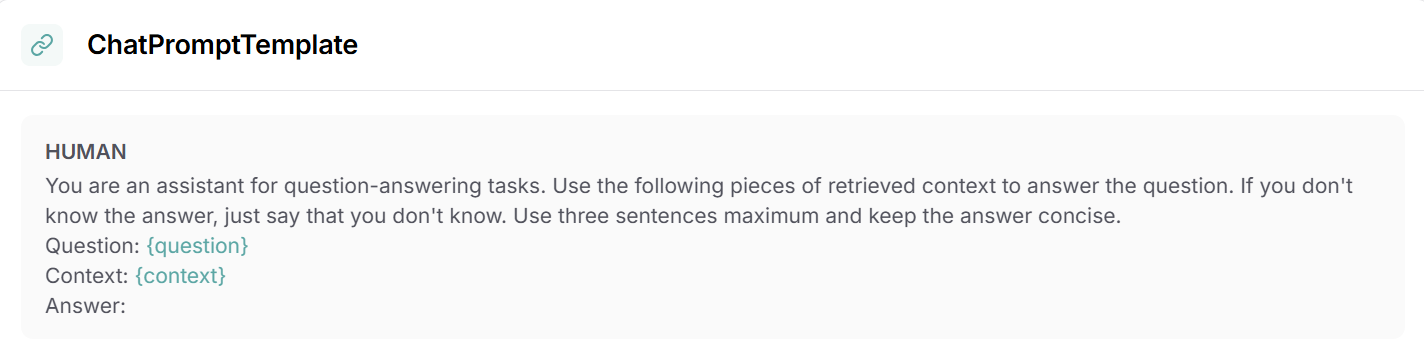

In [14]:
# put the retrieved text as context into the prompt template
rag_chain = (
    # context is a variable depends on question and retriever; the question is constant in this pipeline, so it has to be RunnablePassthrough()
    {"context": retriever | format_docs, "question": RunnablePassthrough()}  
    | prompt
    | chat
    | StrOutputParser()
)

In [16]:
# query
rag_res = rag_chain.invoke("What is Task Decomposition?")
print(rag_res)

/root/miniconda3/envs/project/lib/python3.10/site-packages/chromadb/types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x
/root/miniconda3/envs/project/lib/python3.10/site-packages/chromadb/types.py:144: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  return self.model_fields  # pydantic 2.x


Task Decomposition is a method of breaking down complex tasks into smaller, more manageable subtasks. This can be done through various techniques such as Chain of Thought (CoT) and Tree of Thoughts, which involve instructing the model to "think step by step" and explore multiple reasoning paths. The approach helps in planning and executing tasks more effectively by simplifying them into smaller steps.


In [17]:
# delete the collection
chroma_store.delete_collection()